## Import essential libraries

In [2]:
#If new to gseapy or lifelines, install using pip
#pip install gseapy
#pip install lifelines

import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import miner_py3 as miner
import time

import gseapy as gp
from gseapy.plot import gseaplot

Creating directory /Users/mwall/Library/Application Support/bioservices 


## Define local directories

In [6]:
#local path to miner download
miner_directory = os.path.join(os.path.expanduser('~'),
                               'Desktop','miner3-master','miner')
#local path to miner network directory   
network_directory = os.path.join(miner_directory,'myeloma_network')

# create name for results folder where output files will be saved
resultsFolder = "GSEA_results"

# create results directory
resultsDirectory = os.path.join(miner_directory,resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load example data (see download_data and download_network notebooks)

In [15]:
# Load expression Data
expressionFile = os.path.join(miner_directory,"data","expression","IA12Zscore.csv")
#expressionData = pd.read_csv(expressionFile,index_col=0,header=0) #use if data is already normalized
expressionData, conversionTable = miner.preprocess(expressionFile) #not for counts format

# Load mutations
common_mutations = pd.read_csv(os.path.join(miner_directory,'data','mutations','commonMutations.csv'),index_col=0,header=0)
translocations = pd.read_csv(os.path.join(miner_directory,'data','mutations','translocationsIA12.csv'),index_col=0,header=0)
cytogenetics = pd.read_csv(os.path.join(miner_directory,'data','mutations','cytogenetics.csv'),index_col=0,header=0)
cytogenetics = cytogenetics.loc[:,list(set(cytogenetics.columns)&set(expressionData.columns))]
common_patients_mutations_translocations = list(set(translocations.columns)&set(common_mutations.columns))
mutation_matrix = pd.concat([common_mutations.loc[:,common_patients_mutations_translocations],translocations.loc[:,common_patients_mutations_translocations]],axis=0)

#If previous results exist, use miner.read_json to load them
revisedClusters = miner.read_json(os.path.join(network_directory,"coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(network_directory,"coexpressionModules.json"))
regulonModules = miner.read_json(os.path.join(network_directory,"regulons.json"))
mechanisticOutput = miner.read_json(os.path.join(network_directory,"mechanisticOutput.json"))
regulonDf = pd.read_csv(os.path.join(network_directory,"regulonDf.csv"),index_col=0,header=0)
overExpressedMembersMatrix = pd.read_csv(os.path.join(network_directory,"overExpressedMembers.csv"),index_col=0,header=0)
overExpressedMembersMatrix.index = np.array(overExpressedMembersMatrix.index).astype(str)
underExpressedMembersMatrix = pd.read_csv(os.path.join(network_directory,"underExpressedMembers.csv"),index_col=0,header=0)
underExpressedMembersMatrix.index = np.array(underExpressedMembersMatrix.index).astype(str)
eigengenes = pd.read_csv(os.path.join(network_directory,"eigengenes.csv"),index_col=0,header=0)
eigengenes.index = np.array(underExpressedMembersMatrix.index).astype(str)

#Load table for converting gene names
id_table_path = os.path.join(miner_directory,"data","identifier_mappings.txt")
id_table = pd.read_csv(id_table_path,sep="\t")
id_table = id_table[id_table["Source"] == "Gene Name"]
id_table.index = id_table.iloc[:,0]

# Load transcriptional programs
transcriptional_programs = miner.read_json(os.path.join(network_directory,'transcriptional_programs.json'))
program_list = [transcriptional_programs[str(key)] for key in range(len(transcriptional_programs.keys()))]

# Load transcriptional states
transcriptional_states = miner.read_json(os.path.join(network_directory,'transcriptional_states.json'))
states_list = [transcriptional_states[str(key)] for key in range(len(transcriptional_states.keys()))]
final_state = list(set(expressionData.columns)-set(np.hstack(states_list)))
if len(final_state)>0:
    states_list.append(final_state)
states = states_list.copy()
diff_matrix_MMRF = overExpressedMembersMatrix-underExpressedMembersMatrix

states_df = pd.DataFrame(np.zeros((len(states),expressionData.shape[1])))
states_df.index = list(range(1,len(states)+1))
states_df.columns = expressionData.columns

for i in range(len(states)):
    states_df.loc[i+1,states[i]] = 1
    
# load primary survival data (i.e., corresponding to expression data training set)
survivalMMRF = pd.read_csv(os.path.join(miner_directory,"data","survival","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
kmDfMMRF = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
guanSurvivalDfMMRF= miner.guanRank(kmSurvival=kmDfMMRF)

print('Data loading complete')

completed identifier conversion.
16216 genes were converted.
Data loading complete


## List available default databases for GSEA

In [8]:
gp.get_library_name()

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'Cancer_Cell_Line_Encyclopedia',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'DisGeNET',
 'Disease_Perturbations_from_GEO_down',
 'Disease_Perturbations_from_GEO_up',
 'Disease_Signatures_from_GEO_down_2014',
 'Disease_Signatures_from_GEO_up_2014',
 'DrugMatrix',
 'Drug_Perturbations

## Perform GSEA on differentially expressed genes of a single state

In [11]:
# Define two phenotypes for comparison    
state_ix = 14 #note: python indices start at 0, so states[14], states_df.loc[15,:], and state TS-15 are the same
phenotype1 =  states[state_ix]
phenotype2 = miner.setdiff(expressionData.columns,phenotype1)

#start timer
t1 = time.time()

#Define the reference database
gs_db = 'Drug_Perturbations_from_GEO_down'

#Use Wilcoxon rank-sums to rank differential expression between phenotypes
wilcox_stats_w = []
wilcox_stats_p = []
for j in expressionData.index:
    tmp_wilcox = stats.ranksums(expressionData.loc[j,phenotype1],expressionData.loc[j,phenotype2])
    wilcox_stats_w.append(tmp_wilcox[0])
    wilcox_stats_p.append(tmp_wilcox[1])

# Produce formatted output for GSEA
rnk_st_21 = pd.DataFrame(np.vstack([wilcox_stats_w,wilcox_stats_p]).T)
rnk_st_21.index = expressionData.index
rnk_st_21.sort_values(by=0,ascending=False,inplace=True)
rnk_st_21_hgnc = miner.gene_conversion(rnk_st_21.index,id_table = id_table,list_symbols=True)
rnk_st_21.index = rnk_st_21_hgnc
rnk_st_21.drop(1,axis=1,inplace=True)
rnk_st_21.head()

# note: multiprocessing may not work on windows; takes about 10s on MacBook Air
savefile = ("_").join(["State",str(state_ix),gs_db])
pre_res = gp.prerank(rnk=rnk_st_21, gene_sets=gs_db,
                     processes=20,
                     permutation_num=100, # reduce number to speed up testing
                     outdir=savefile, format='png', seed=6)

# Get tabulated results
gsea_results = pre_res.res2d
gsea_results.sort_values(by="nes",ascending=False,inplace=True)

#end timer
t2 = time.time()
print('completed gsea in {:.2f} minutes'.format((t2-t1)/60.))    

#display results
gsea_results.head()

completed gsea in 6.86 minutes


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
PD173074 1401 human GSE52452 sample 2578,0.788369,4.017727,0.0,0.0,439,383,MCM4;TRIP13;PLK1;NUF2;MCM3;DLGAP5;KIF2C;MCM10;...,MCM4;TRIP13;PLK1;NUF2;MCM3;DLGAP5;KIF2C;MCM10;...
vemurafenib DB08881 human GSE37441 sample 2561,0.780252,3.780628,0.0,0.0,335,306,MCM4;TRIP13;PLK1;NUF2;MCM3;DLGAP5;PA2G4;KIF2C;...,MCM4;TRIP13;PLK1;NUF2;MCM3;DLGAP5;PA2G4;KIF2C;...
resveratrol DB02709 human GSE25412 sample 3500,0.749195,3.710595,0.0,0.0,350,303,MCM4;TRIP13;PLK1;NUF2;MCM3;DLGAP5;KIF2C;MCM10;...,MCM4;TRIP13;PLK1;NUF2;MCM3;DLGAP5;KIF2C;MCM10;...
vemurafenib DB08881 human GSE37441 sample 2564,0.737099,3.625529,0.0,0.0,358,332,MCM4;TRIP13;PLK1;NUF2;MCM3;DLGAP5;PA2G4;KIF2C;...,MCM4;TRIP13;PLK1;NUF2;MCM3;DLGAP5;PA2G4;KIF2C;...
resveratrol DB02709 human GSE25412 sample 3501,0.716485,3.566232,0.0,0.0,406,358,MCM4;TRIP13;PLK1;NUF2;MCM3;DLGAP5;KIF2C;MCM10;...,MCM4;TRIP13;PLK1;NUF2;MCM3;DLGAP5;KIF2C;MCM10;...


## Generate GSEA plot

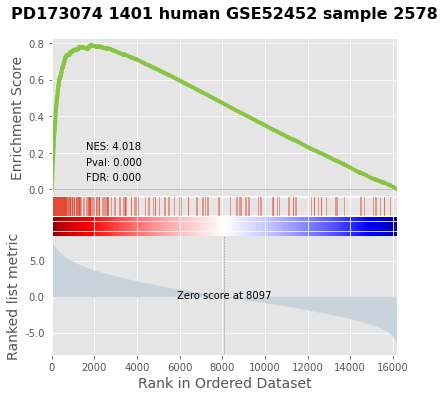

In [12]:
#Generate figure
terms = gsea_results.index
term_ix = 0
gseaplot(rank_metric=pre_res.ranking, term=terms[term_ix], **pre_res.results[terms[term_ix]])

# save figure (ofname must not be None)
# gseaplot(rank_metric=pre_res.ranking, term=terms[0], ofname='your.plot.pdf', **pre_res.results[terms[0]])

## Perform hallmark enrichment analysis on each state

In [13]:
#start timer
t1 = time.time()
state_hallmarks_dfs = []
for i in range(len(states)):
    
    # Print status update
    t_tmp = time.time()
    elapsed = float(t_tmp-t1)/60
    print("performing iteration {:d} of {:d}".format(i+1,len(states)+1))
    print("time elapsed: {:.2f} minutes".format(elapsed))
    
    # Define two phenotypes for comparison    
    phenotype1 =  states[i]
    phenotype2 = miner.setdiff(expressionData.columns,phenotype1)

    #Use Wilcoxon rank-sums to rank differential expression between phenotypes
    wilcox_stats_w = []
    wilcox_stats_p = []
    for j in expressionData.index:
        tmp_wilcox = stats.ranksums(expressionData.loc[j,phenotype1],expressionData.loc[j,phenotype2])
        wilcox_stats_w.append(tmp_wilcox[0])
        wilcox_stats_p.append(tmp_wilcox[1])

    # Produce formatted output for GSEA
    rnk_st_21 = pd.DataFrame(np.vstack([wilcox_stats_w,wilcox_stats_p]).T)
    rnk_st_21.index = expressionData.index
    rnk_st_21.sort_values(by=0,ascending=False,inplace=True)
    rnk_st_21_hgnc = miner.gene_conversion(rnk_st_21.index,id_table = id_table,list_symbols=True)
    rnk_st_21.index = rnk_st_21_hgnc
    rnk_st_21.to_csv(os.path.join(resultsDirectory,("_").join(["state",str(i),"diff_exp.csv"])))
    rnk_st_21.drop(1,axis=1,inplace=True)
    rnk_st_21.head()

    # note: multiprocessing may not work on windows; takes about 10s on MacBook Air
    gs_db = 'MSigDB_Hallmark_2020'
    savefile = ("_").join(["State",str(state_ix),gs_db])
    pre_res = gp.prerank(rnk=rnk_st_21, gene_sets=gs_db,
                         processes=20,
                         permutation_num=100, # reduce number to speed up testing
                         outdir=savefile, format='png', seed=6)
    gsea_results = pre_res.res2d

    #save output to files
    miner.write_pkl(pre_res,os.path.join(resultsDirectory,("_").join(["state",str(i),"hallmarks","gsea.pkl"])))
    gsea_results.to_csv(os.path.join(resultsDirectory,("_").join(["state",str(i),"hallmarks","gsea.csv"])))
    
    #Append df to state_hallmarks_dfs
    state_hallmarks_dfs.append(gsea_results)
    
t_tmp = time.time()
elapsed = float(t_tmp-t1)/60
print('completed iterations in {:.2f} minutes'.format(elapsed))


performing iteration 1 of 27
time elapsed: 0.00 minutes
performing iteration 2 of 27
time elapsed: 0.86 minutes
performing iteration 3 of 27
time elapsed: 1.72 minutes
performing iteration 4 of 27
time elapsed: 2.55 minutes
performing iteration 5 of 27
time elapsed: 3.49 minutes
performing iteration 6 of 27
time elapsed: 4.34 minutes
performing iteration 7 of 27
time elapsed: 5.22 minutes
performing iteration 8 of 27
time elapsed: 6.00 minutes
performing iteration 9 of 27
time elapsed: 6.78 minutes
performing iteration 10 of 27
time elapsed: 7.61 minutes
performing iteration 11 of 27
time elapsed: 8.43 minutes
performing iteration 12 of 27
time elapsed: 9.22 minutes
performing iteration 13 of 27
time elapsed: 9.99 minutes
performing iteration 14 of 27
time elapsed: 10.94 minutes
performing iteration 15 of 27
time elapsed: 11.90 minutes
performing iteration 16 of 27
time elapsed: 12.82 minutes
performing iteration 17 of 27
time elapsed: 13.71 minutes
performing iteration 18 of 27
time e

## Format enrichments into dataframe and correlate to risk

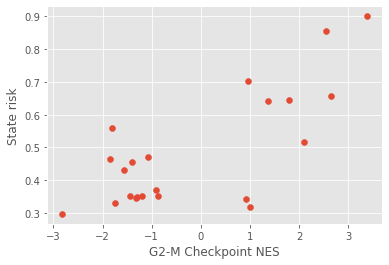

In [26]:
state_id = []
state_risk = []
nes_scores = []
for i in range(len(states)):
    matched_pats = miner.intersect(states[i],guanSurvivalDfMMRF.index)
    if len(matched_pats) < 5:
        continue
    risk = np.median(guanSurvivalDfMMRF.loc[matched_pats,"GuanScore"])
    state_id.append(i+1)
    state_risk.append(risk)
    
    gsea_results = pd.read_csv(os.path.join(resultsDirectory,("_").join(["state",str(i),"hallmarks","gsea.csv"])),index_col=0,header=0)
    gsea_results.sort_values(by="nes",ascending=False,inplace=True)
    if i == 0:
        hallmark_index = gsea_results.index
    
    nes_df = pd.DataFrame(gsea_results.loc[hallmark_index,"nes"])
    nes_df.columns = [str(i+1)]
    nes_scores.append(nes_df)
    
# Concatenate enrichments into dataframe
nes_df = pd.concat(nes_scores,axis=1)  

# Correlate enrichments to risk
state_risk_correlation = miner.pearson_array(np.array(nes_df),np.array(state_risk))

# List terms in order of increasing risk
nes_df = nes_df.iloc[np.argsort(state_risk_correlation),:]

# Scatterplot of highest-risk enrichment versus risk
plt.scatter(nes_df.loc[nes_df.index[-1],:],state_risk)
plt.ylabel("State risk")
plt.xlabel(nes_df.index[-1] + " NES")
plt.show()

## Generate standard cluster heatmap

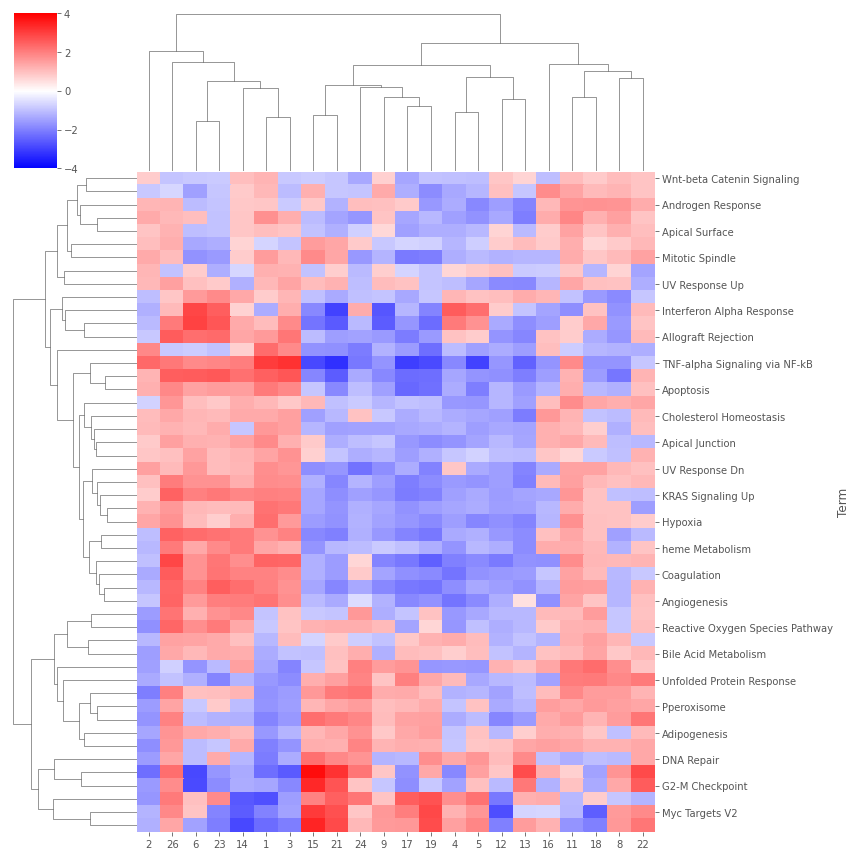

In [27]:
import seaborn as sns
g = sns.clustermap(nes_df.loc[:,:],figsize=(12,12),cmap="bwr",vmin=-4,vmax=4)
g
plt.grid(False)
plt.savefig(os.path.join(resultsDirectory,"states_hallmarks_clustermap.pdf"),bbox_inches="tight")

## Generate heatmap with ordered states

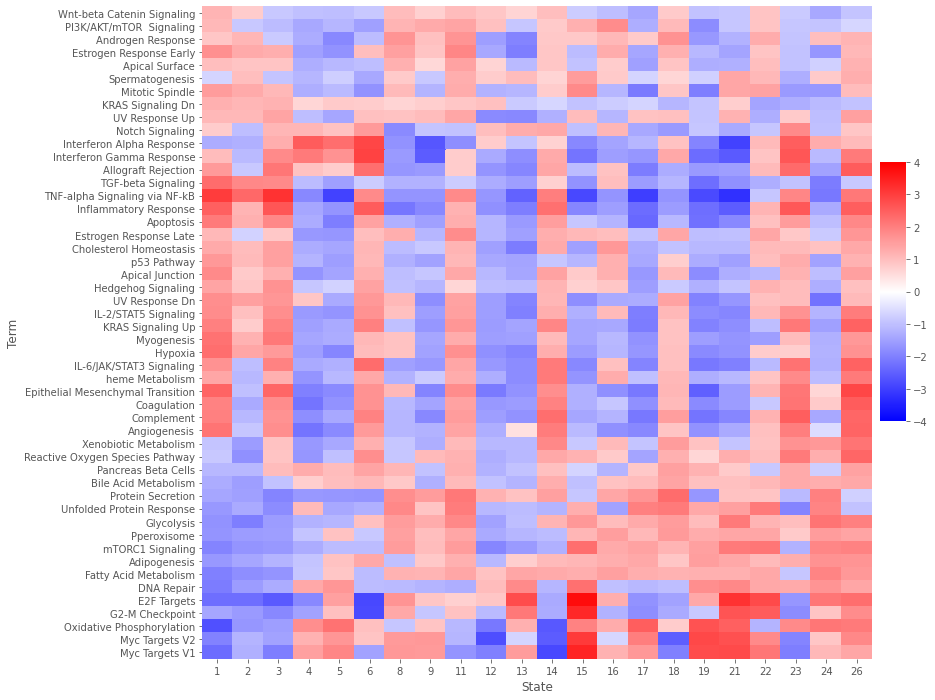

In [28]:
#Retrive hierarchical clustering ordering of hallmark enrichments
ordered_hallmarks = nes_df.index[g.dendrogram_row.reordered_ind]

#Plot heatmap with normal order of states
fig, ax = plt.subplots(1, 1)
fig.set_figheight(12)
fig.set_figwidth(12)
cbar_ax = fig.add_axes([.91, .4, .03, .3])
sns.heatmap(nes_df.loc[ordered_hallmarks,:],
            ax=ax, cbar_ax = cbar_ax, cbar=True,cmap="bwr",vmin=-4,vmax=4)
ax.set_xlabel("State")
plt.savefig(os.path.join(resultsDirectory,"states_hallmarks_heatmap_numeric.pdf"),bbox_inches="tight")